In [1]:
import json
import smart_open
import pandas as pd
import os

# RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"
# MODEL_PATH = "olmo/1b/olmo-small-dolma-150B-mcli-results"
RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"
MODEL_PATH = "pythia/1b"

model_path = os.path.join(RESULTS_DIR, MODEL_PATH)

domains_with_subdomains = set()
for sheet_name in os.listdir(model_path):
    if sheet_name.endswith("subdomains.jsonl.gz") and not sheet_name.startswith("bits_per_byte"):
        domains_with_subdomains.add("_".join(sheet_name.split("_")[2:-1]))
    # print(sheet_name)

shared_cols = {
 'model',
 'model_size',
 'split',
 'tokens_seen',
 'training_dataset',
 'training_steps'
 }

non_domain_cols = {
    "date",
    "model",
    "model_kwargs",
    "full_model",
    "task",
    "processing_time",
    "num_instances",
    "tango_workspace",
    "tango_step",
    "model_max_length",
    "max_batch_tokens",
    "batch_size",
    "limit",
    "split",
    "random_subsample_seed",
    "model_size",
    "training_steps",
    "tokens_seen",
    "training_dataset"
}

def standardize_model_metadata(row):
    if row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-dolma-150B-mcli'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'model_kwargs' in row:
            assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
            del row['model_kwargs']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'Dolma V1.5'
    elif row['model'].startswith('EleutherAI/pythia-1b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 805736448 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    else:
        # pass
        raise ValueError(f"Unknown model: {row['model']}")
    return row

def read_jsonl(path):
    with smart_open.open(path, 'rt') as fin:
        for line in fin:
            data = standardize_model_metadata(json.loads(line))
            yield data

domains_without_subdomains = set(pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))['task']) - domains_with_subdomains


In [2]:

# ppl_redpajama_token_count_avg_logits = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_redpajama_token_count_avg_logits.jsonl.gz")))
# ppl_redpajama_token_count_avg_logits.head()
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.jsonl.gz")))
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains
# ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
# ppl_metrics.head()

In [8]:
from functools import reduce

def make_subdomain_of_task(model_path, task_names, metric_name):
    ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
    dfs = []
    assert set(task_names) <= set(ppl_metrics['task'])
    for task_name in task_names:
        task_df = ppl_metrics[ppl_metrics['task'] == task_name]
        new_df = task_df[list(shared_cols)].copy()
        new_df[task_name] = task_df[metric_name]
        dfs.append(new_df)
    
    return dfs

def get_metric_for_all_subdomains(model_path, sheet_names, metrics_name, include_non_subdomain_tasks=None):
    dfs = []
    if include_non_subdomain_tasks:
        dfs.extend(make_subdomain_of_task(model_path, include_non_subdomain_tasks, metrics_name))
    for k in sheet_names:
        if not k.endswith('subdomains.jsonl.gz'):
            continue
        if k.startswith(metrics_name):
            df = pd.DataFrame(read_jsonl(os.path.join(model_path, k)))
            
            df = df[list(df.columns.difference(non_domain_cols - shared_cols))]
            dfs.append(df)
    
    # join all the dfs on the domain cols, by concatenating the domain cols
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), dfs)
    return merged_df

def get_avg_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['avg_over_subdomains'] = df[domain_cols].mean(axis=1)
    return new_df

In [14]:
def get_avg_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['avg_over_subdomains'] = df[domain_cols].mean(axis=1)
    return new_df
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_ppl_token_all_domains_avg = get_avg_over_all_subdomains(get_metric_for_all_subdomains(model_path, os.listdir(model_path), 'ppl_token', domains_without_subdomains))
pythia_ppl_token_all_domains_avg

,training_dataset,split,training_steps,model,tokens_seen,model_size,avg_over_subdomains
0,The Pile,test,10000,pythia,20971520000,805736448,19.216027
1,The Pile,test,20000,pythia,41943040000,805736448,17.475870
2,The Pile,test,30000,pythia,62914560000,805736448,16.714318
3,The Pile,test,40000,pythia,83886080000,805736448,16.235808
4,The Pile,test,50000,pythia,104857600000,805736448,15.924628
5,The Pile,test,60000,pythia,125829120000,805736448,15.603757
6,The Pile,test,70000,pythia,146800640000,805736448,15.319996
7,The Pile,test,80000,pythia,167772160000,805736448,15.088109
8,The Pile,test,90000,pythia,188743680000,805736448,15.007228
9,The Pile,test,100000,pythia,209715200000,805736448,14.677901


In [15]:
model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_ppl_token_all_domains_avg = get_avg_over_all_subdomains(get_metric_for_all_subdomains(model_path, os.listdir(model_path), 'ppl_token', domains_without_subdomains))
dolma_ppl_token_all_domains_avg

,training_dataset,split,training_steps,model,tokens_seen,model_size,avg_over_subdomains
0,Dolma V1.5,test,5000,olmo,21626880000,1177240704,19.832794
1,Dolma V1.5,test,10000,olmo,43253760000,1177240704,18.388410
2,Dolma V1.5,test,15000,olmo,64880640000,1177240704,17.070878
3,Dolma V1.5,test,20000,olmo,86507520000,1177240704,15.258691
4,Dolma V1.5,test,25000,olmo,108134400000,1177240704,14.778055
5,Dolma V1.5,test,30000,olmo,129761280000,1177240704,14.552465
6,Dolma V1.5,test,35000,olmo,151388160000,1177240704,14.352160


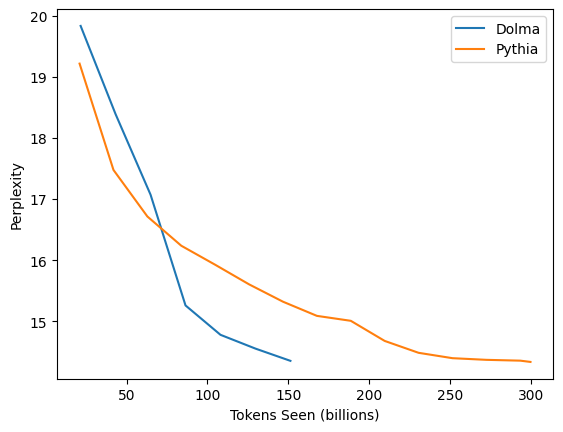

In [17]:
# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = dolma_ppl_token_all_domains_avg['tokens_seen'] / 1000000000
dolma_y_axis = dolma_ppl_token_all_domains_avg['avg_over_subdomains']

pythia_x_axis = pythia_ppl_token_all_domains_avg['tokens_seen'] / 1000000000
pythia_y_axis = pythia_ppl_token_all_domains_avg['avg_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

## Per token

In [3]:
df = pd.DataFrame(results['ppl_redpajama_token_count_avg_logits'])
df

,model,model_kwargs,subdomain,token,count,avg_logits
0,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__arxiv,Fund,1,-16.910574
1,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__arxiv,OR,1,-16.874359
2,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__arxiv,:_,1,-15.613811
3,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__arxiv,Being,1,-15.429646
4,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__arxiv,initial,2,-15.279208
...,...,...,...,...,...,...
68336,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__wikipedia,arde,1,-0.000095
68337,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__wikipedia,assadors,1,-0.000056
68338,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__wikipedia,inth,1,-0.000053
68339,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__wikipedia,ioned,1,-0.000012


In [11]:
# show the top 10 tokens with the highest average logit
df.sort_values(by='avg_logits', ascending=False).head(10)

,model,model_kwargs,subdomain,token,count,avg_logits
17134,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__books,iece,1,-2.384186e-07
49036,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,BASIS,2,-1.728533e-06
57206,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__stackexchange,dtd,1,-2.503392e-06
49035,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,OR,2,-4.827956e-06
44559,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__commoncrawl,rest,1,-4.887569e-06
17133,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__books,oys,2,-6.258457e-06
49034,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,OF,2,-6.437280e-06
49033,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,ANY,2,-8.106198e-06
49032,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,KIND,2,-8.165800e-06
49031,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,licenses,2,-8.463824e-06


In [10]:
# show most common tokens
df.sort_values(by='count', ascending=False).head(10)

,model,model_kwargs,subdomain,token,count,avg_logits
48235,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,\n,7404,-0.205430
55650,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__stackexchange,\n,5984,-0.636155
48309,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,.,5761,-0.165911
6112,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__arxiv,\n,4750,-0.555916
15277,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__books,",",4710,-1.207286
48272,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__github,_,4546,-0.183955
28713,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__c4,.,4319,-0.959059
15235,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__books,the,4234,-1.254945
55771,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__stackexchange,.,3648,-0.534855
66822,EleutherAI/pythia-1b,"{'revision': 'step140000', 'trust_remote_code'...",redpajama__wikipedia,\n,3601,-0.719567


## MISC

In [ ]:
# import json
# import smart_open
# import pandas as pd


# # with gzip.open('toy_token_avg_logits_data.json.gz', 'rt') as fin: 
# with smart_open.open('/Users/ianm/projects/ppl-suite-paper-runs/olmo-small-dolma-150B-mcli-results.json.gz', 'rt') as fin:
# # with smart_open.open('/Users/ianm/projects/ppl-suite-paper-runs/test_output.json.gz', 'rt') as fin:
#     results = json.load(fin)

In [ ]:
# import os
# os.makedirs('olmo-small-dolma-150B-mcli-results', exist_ok=True)
# for table_name in results:
#     output_file = os.path.join('olmo-small-dolma-150B-mcli-results', table_name + ".jsonl.gz")
#     with smart_open.open(output_file, "wb") as f:
#         print(f"writing {table_name} to file")
#         for row in results[table_name]:
#             f.write(json.dumps(row).encode())
#             f.write(b"\n")